<a href="https://colab.research.google.com/github/harperd17/energy_volatility_prediction/blob/main/notebooks/SUSB_ingestion_all_years.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gather Data 2001 - 2018 from SUSB for back fill of electric accounts

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import spacy

import requests
import xlrd
import urllib
from google.colab import drive

!pip install us
import us

In [2]:
drive.mount('/content/drive/')

Mounted at /content/drive/


## Get the data for each year

In [3]:
# this contains the information needed to properly gather the data for each year - this is necessary because the data changes so much year to year
metadata = {
    '2001':{
        'link': 'https://www2.census.gov/programs-surveys/susb/tables/2001/state_naicssector_2001.xls',
        'header row':[7],
        'columns':['STATE', 'CODE', 'DESCRIPTION', 'DATA TYPE', 'TOTAL', '0',
                    '1-4', '5-9', '10-19', '<20', '20-99', '100-499', '<500', '500+']
    },
    '2002':{
        'link':'https://www2.census.gov/programs-surveys/susb/tables/2002/state_naicssector_2002.xls',
        'header row':[5,6],
        'columns':['STATE','CODE','DESCRIPTION', 'DATA TYPE', 'TOTAL', '0',
                    '1-4', '5-9', '10-19', '<20', '20-99', '100-499', '<500', '500+']
    },
    '2003':{
        'link':'https://www2.census.gov/programs-surveys/susb/tables/2003/state_naicssector_2003.xls',
        'header row':[7],
        'columns':['STATE','CODE','DESCRIPTION', 'DATA TYPE', 'TOTAL', '0',
                    '1-4', '5-9', '10-19', '<20', '20-99', '100-499', '<500', '500+']
    },
    '2004':{
        'link':'https://www2.census.gov/programs-surveys/susb/tables/2004/state_naicssector_2004.xls',
        'header row':[7],
        'columns':['STATE','CODE','DESCRIPTION', 'DATA TYPE', 'TOTAL', '0',
                    '1-4', '5-9', '10-19', '<20', '20-99', '100-499', '<500', '500+']
    },
    '2005':{
        'link':'https://www2.census.gov/programs-surveys/susb/tables/2005/state_naicssector_2005.xls',
        'header row':[7],
        'columns':['STATE', 'CODE', 'DESCRIPTION', 'DATA TYPE', 'TOTAL', '0-4',
                    '5-9', '10-19', '<20', '20-99', '100-499', '<500', '500+']
    },
    '2006':{
        'link':'https://www2.census.gov/programs-surveys/susb/tables/2006/state_naicssector_2006.xls',
        'header row':[7],
        'columns':['STATE','CODE','DESCRIPTION', 'DATA TYPE', 'TOTAL',
                    '0-4', '5-9', '10-19', '<20', '20-99', '100-499', '<500', '500+']
    },
    '2007':{
        'link':'https://www2.census.gov/programs-surveys/susb/tables/2007/state_naicssector_2007.xls',
        'header row':[5,6],
        'columns':['STATE', 'CODE', 'DESCRIPTION', 'SIZE','FIRMS', 'ESTABLISHMENTS',
                  'EMPLOYMENT', 'EMPLOYMENT RANGE FLAG','EMPLOYMENT NOISE FLAG', 'PAYROLL', 'PAYROLL NOISE FLAG', 'RECEIPTS','RECEIPTS NOISE FLAG'],
        'pivot':True
    },
    '2008':{
        'link':'https://www2.census.gov/programs-surveys/susb/tables/2008/state_naicssector_2008.xls',
        'header row':[5],
        'columns':['STATE CODE', 'STATE', 'CODE', 'DESCRIPTION', 'SIZE','FIRMS', 'ESTABLISHMENTS', 'EMPLOYMENT', 'RANGE FLAG',
                  'NOISE FLAG', '-1000', 'NOISE FLAG.1'],
        'pivot':True
    },
    '2009':{
        'link':'https://www2.census.gov/programs-surveys/susb/tables/2009/state_naicssector_2009.xls',
        'header row':[4],
        'columns':['STATE CODE', 'STATE', 'CODE','DESCRIPTION', 'SIZE', 'FIRMS', 'ESTABLISHMENTS', 'EMPLOYMENT',
                  'EMPLOYMENT RANGE FLAG', 'EMPLOYMENT NOISE FLAG', 'ANNUAL PAYROLL ($1,000)', 'ANNUAL PAYROLL NOISE FLAG'],
        'pivot':True
    },
    '2010':{
        'link':'https://www2.census.gov/programs-surveys/susb/tables/2010/state_naicssector_2010.xls',
        'header row':[4],
        'columns':['STATE CODE', 'STATE', 'CODE', 'DESCRIPTION', 'SIZE','FIRMS', 'ESTABLISHMENTS', 'EMPLOYMENT',
                'EMPLOYMENT RANGE FLAG', 'EMPLOYMENT NOISE FLAG','ANNUAL PAYROLL ($1,000)', 'ANNUAL PAYROLL NOISE FLAG'],
        'pivot':True
    },
    '2011':{
        'link':'https://www2.census.gov/programs-surveys/susb/tables/2011/state_naicssector_2011.xls',
        'header row':[4],
        'columns':['STATE CODE', 'STATE', 'CODE','DESCRIPTION', 'SIZE','FIRMS', 'ESTABLISHMENTS', 'EMPLOYMENT',
                  'EMPLOYMENT RANGE FLAG', 'EMPLOYMENT NOISE FLAG','ANNUAL PAYROLL ($1,000)', 'ANNUAL PAYROLL NOISE FLAG'],
       'pivot':True
    },
    '2012':{
        'link':'https://www2.census.gov/programs-surveys/susb/tables/2012/state_naicssector_2012.xls',
        'header row':[5],
        'columns':['STATE CODE', 'STATE', 'CODE','DESCRIPTION', 'SIZE', 'FIRMS', 'ESTABLISHMENTS', 'EMPLOYMENT',
                  'EMPLOYMENT RANGE FLAG', 'EMPLOYMENT NOISE FLAG','ANNUAL PAYROLL ($1,000)', 'ANNUAL PAYROLL NOISE FLAG', 'RECEIPTS      ($1,000)', 'RECEIPTS NOISE FLAG'],
        'pivot':True
    },
    '2013':{
        'link':'https://www2.census.gov/programs-surveys/susb/tables/2013/state_naicssector_2013.xlsx',
        'header row':[5],
        'columns':['STATE CODE', 'STATE', 'CODE','DESCRIPTION', 'SIZE', 'FIRMS', 'ESTABLISHMENTS', 'EMPLOYMENT',
                  'EMPLOYMENT RANGE FLAG', 'EMPLOYMENT NOISE FLAG', 'ANNUAL PAYROLL ($1,000)', 'ANNUAL PAYROLL NOISE FLAG'],
        'pivot':True
    },
    '2014':{
        'link':'https://www2.census.gov/programs-surveys/susb/tables/2014/state_naicssector_2014.xlsx',
        'header row':[5],
        'columns':['STATE CODE', 'STATE', 'CODE','DESCRIPTION', 'SIZE','FIRMS', 'ESTABLISHMENTS', 'EMPLOYMENT',
                'EMPLOYMENT RANGE FLAG', 'EMPLOYMENT NOISE FLAG','ANNUAL PAYROLL ($1,000)', 'ANNUAL PAYROLL NOISE FLAG'],
        'pivot':True
    },
    '2015':{
        'link':'https://www2.census.gov/programs-surveys/susb/tables/2015/state_naicssector_2015.xlsx',
        'header row':[5],
        'columns':['STATE CODE', 'STATE', 'CODE','DESCRIPTION', 'SIZE','FIRMS', 'ESTABLISHMENTS', 'EMPLOYMENT',
                  'EMPLOYMENT RANGE FLAG', 'EMPLOYMENT NOISE FLAG','ANNUAL PAYROLL ($1,000)', 'ANNUAL PAYROLL NOISE FLAG'],
        'pivot':True
    },
    '2016':{
        'link':'https://www2.census.gov/programs-surveys/susb/tables/2016/state_naicssector_2016.xlsx',
        'header row':[6],
        'columns':['STATE CODE', 'STATE', 'CODE','DESCRIPTION', 'SIZE','FIRMS', 'ESTABLISHMENTS', 'EMPLOYMENT',
                  'EMPLOYMENT RANGE FLAG', 'EMPLOYMENT NOISE FLAG','ANNUAL PAYROLL ($1,000)', 'ANNUAL PAYROLL NOISE FLAG'],
        'pivot':True
    },
    '2017':{
        'link':'https://www2.census.gov/programs-surveys/susb/tables/2017/us_state_6digitnaics_2017.xlsx',
        'header row':[2],
        'columns':['STATE CODE', 'STATE', 'CODE', 'DESCRIPTION','SIZE', 'FIRMS', 'ESTABLISHMENTS', 'EMPLOYMENT','Employment\nRange Flag', 'Employment Noise Flag',
                   'Annual Payroll\n($1,000)', 'Annual Payroll Noise Flag','Receipts\n($1,000)', 'Receipts\nNoise Flag'],
        'pivot':True
    },
    '2018':{
        'link':'https://www2.census.gov/programs-surveys/susb/tables/2018/us_state_6digitnaics_2018.xlsx',
        'header row':[2],
        'columns':['STATE CODE', 'STATE', 'CODE', 'DESCRIPTION', 'SIZE', 'FIRMS', 'ESTABLISHMENTS', 'EMPLOYMENT',
                  'Employment Noise Flag', 'Annual Payroll\n($1,000)','Annual Payroll Noise Flag'],
        'pivot':True
    }
}

In [4]:
# go through each year and gather the data and append the df for each year to list
all_dfs_raw = []
dfs_to_keep_2001_2006 = []
dfs_to_keep_2007_2018 = []
for year in metadata:
  print(year)
  year_info = metadata[year]
  df = pd.read_excel(year_info['link'],header=year_info['header row'])
  df.columns = year_info['columns']
  df['YEAR'] = [int(year)]*df.shape[0]
  all_dfs_raw.append(df)
  if int(year) <= 2006:
    dfs_to_keep_2001_2006.append(df[['YEAR','STATE','CODE','DESCRIPTION', 'DATA TYPE', 'TOTAL']].copy())
  else:
    dfs_to_keep_2007_2018.append(df[['YEAR','STATE', 'CODE','DESCRIPTION', 'SIZE','FIRMS', 'ESTABLISHMENTS', 'EMPLOYMENT']].copy())

2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018


### First deal with the 2001-2006 data. I will pivot this data so that the different values (employment, firms, and establishments) are columns instead of taking up a whole row for each

In [5]:
# append all the 2001 through 2006 data together
df_2001_2006 = pd.concat(dfs_to_keep_2001_2006).reset_index(drop=True)
# append all the 2007 thorugh 2018 data together
df_2007_2018 = pd.concat(dfs_to_keep_2007_2018).reset_index(drop=True)

In [6]:
# I like the representation of having FIRMS, ESTABLISHMENTS, and EMPLOYMENT as their own columns so I will make the 2001 thorugh 2006 data match that representation
df_2001_2006 = df_2001_2006.pivot(index=['STATE','DESCRIPTION','YEAR'], columns='DATA TYPE', values='TOTAL').reset_index()

In [7]:
# we don't need all the variables
df_2001_2006 = df_2001_2006[['STATE','DESCRIPTION','YEAR','Employment','Establishments','Firms']].copy()

In [8]:
df_2001_2006.head()

DATA TYPE,STATE,DESCRIPTION,YEAR,Employment,Establishments,Firms
0,Alabama,Accommodation & foodservices,2001,127776,6870,4697
1,Alabama,Accommodation & foodservices,2002,128964,7070,4801
2,Alabama,Accommodation and Food Services,2003,139440,7178,4918
3,Alabama,Accommodation and Food Services,2004,141442,7292,5089
4,Alabama,Accommodation and Food Services,2005,145447,7529,5256


In [9]:
df_2001_2006.isnull().sum()

DATA TYPE
STATE             0
DESCRIPTION       0
YEAR              0
Employment        0
Establishments    0
Firms             0
dtype: int64

## Now deal with the 2007-2018 data. For these I only want to keep the "total" and get rid of the other breakdowns such as 0-4, 5-9, ...500+.

In [10]:
# first I need to inspect the unique ways that establishment size have been written out over the years. It looks like I just need to search for 'total' being in the name (as lower case)
df_2007_2018['SIZE'].unique()

array(['1:   Total', '2:   0-4', '3:   5-9', '4:   10-19', '5:   <20',
       '6:   20-99', '7:   100-499', '8:   <500', '9:   500+', nan,
       '01:  Total', '02:  0-4', '03:  5-9', '04:  10-19', '05:  <20',
       '06:  20-99', '07:  100-499', '08:  <500', '09:  500+',
       '01: Total', '02: <5 employees', '03: 5-9 employees',
       '04: 10-19 employees', '05: <20 employees', '06: 20-99 employees',
       '07: 100-499 employees', '08: <500 employees',
       '09: 500+ employees'], dtype=object)

In [11]:
# I will now make a new column that determines if 'total' is in the lower case string for each value in the SIZE column. Then I will subset based on that
df_2007_2018['Total Size'] = df_2007_2018['SIZE'].str.lower().str.contains('total')
# some of the years of data had a few blank rows below the header which results in 16 n/a values in this 'Total Size' column (they are n/a everywhere else too) so I will make those False too so they go away
df_2007_2018['Total Size'] = df_2007_2018['Total Size'].fillna(False)
# subset to where the row is for total and only keep a subset of the columns
df_2007_2018 = df_2007_2018[df_2007_2018['Total Size']][['YEAR','STATE','DESCRIPTION','FIRMS','ESTABLISHMENTS','EMPLOYMENT']]

In [12]:
# now the column names need to be consistent with the column names for the 2001-2006 data
df_2007_2018.columns = ['YEAR','STATE','DESCRIPTION','Firms','Establishments','Employment']

In [13]:
df_2007_2018.head()

,YEAR,STATE,DESCRIPTION,Firms,Establishments,Employment
0,2007,Alabama,Total,81565.0,105627.0,1722834.0
9,2007,Alabama,"Forestry, Fishing, Hunting, and Agriculture Su...",909.0,929.0,7110.0
18,2007,Alabama,Mining,206.0,258.0,8033.0
27,2007,Alabama,Utilities,99.0,389.0,15439.0
36,2007,Alabama,Construction,10334.0,10459.0,114256.0


In [14]:
df_2007_2018.isnull().sum()

YEAR              0
STATE             0
DESCRIPTION       0
Firms             0
Establishments    0
Employment        0
dtype: int64

## Concatenate the dataframes to get a dataframe with years 2001-2018 of data

In [15]:
# concatenate the two sets of years of data
all_years_df = pd.concat([df_2001_2006, df_2007_2018]).reset_index(drop=True)

In [16]:
# some of the data types are just objects and that's because the data has random letters in the numeric fields for some of the rows
# I think these should be replaced with n/a's
all_years_df.dtypes

STATE             object
DESCRIPTION       object
YEAR               int64
Employment        object
Establishments    object
Firms             object
dtype: object

In [17]:
# this function will find all the non numeric values in a column and then replace them with n/a so that the field can become numeric
def replace_non_numeric(df):
  non_numeric = []
  for col in df.columns:
    for i in range(df.shape[0]):
      try:
        float(df[col].iloc[i]) 
      except:
        non_numeric.append(df[col].iloc[i])
  return df.replace(np.unique(non_numeric),np.nan)

In [18]:
# the columns that should be numeric are Employment, Establishments, and Firms
all_years_df[['Establishments','Firms','Employment']] = replace_non_numeric(all_years_df[['Establishments','Firms','Employment']].copy())

In [19]:
all_years_df

,STATE,DESCRIPTION,YEAR,Employment,Establishments,Firms
0,Alabama,Accommodation & foodservices,2001,127776.0,6870.0,4697.0
1,Alabama,Accommodation & foodservices,2002,128964.0,7070.0,4801.0
2,Alabama,Accommodation and Food Services,2003,139440.0,7178.0,4918.0
3,Alabama,Accommodation and Food Services,2004,141442.0,7292.0,5089.0
4,Alabama,Accommodation and Food Services,2005,145447.0,7529.0,5256.0
...,...,...,...,...,...,...
189898,Wyoming,Political Organizations,2018,34.0,13.0,13.0
189899,Wyoming,Political Organizations,2018,34.0,13.0,13.0
189900,Wyoming,"Other Similar Organizations (except Business, ...",2018,70.0,18.0,18.0
189901,Wyoming,"Other Similar Organizations (except Business, ...",2018,70.0,18.0,18.0


# Classification Tagging

In [21]:
nlp = spacy.load("en_core_web_sm") 

def lemmatize(description) -> list():

    for token in doc:
        token_lemma_list.append(token.lemma_.lower())

    return token_lemma_list


description_lemma_dict = dict()

#Iterate through unique description, get lemma and lower description add to dict
unique_descriptions = all_years_df["DESCRIPTION"].unique()


for description in tqdm(unique_descriptions):
    #Turns description in to an interable token list with attrs such as lemma
    doc = nlp(description)
    
    #Keeps trak of current tokens already lemmatized and lower
    token_lemma_list = list()
    
    #Iterate through each token in doc
    for token in doc:
        
        token_lemma_list.append(token.lemma_.lower())
    
    description_lemma_dict.update({description:" ".join(token_lemma_list)})

all_years_df["Description_Lemma_Lower"] = all_years_df["DESCRIPTION"].apply(lambda description: description_lemma_dict[description])
all_years_df["Description_Lower"] = all_years_df["DESCRIPTION"].str.lower()



100%|██████████| 1411/1411 [00:12<00:00, 112.75it/s]


In [22]:
# now add the classifications to the dataframe
def assign_classification(tokens,industry_words,commerical_words):
    try:
        for token in tokens.split(" "):

            for ind_token in industry_words:

                if ind_token in token:

                    return "IND"

            for com_token in commerical_words:

                    if com_token in token:
                        
                        return "COM"
        
        return "OTH"

    except:
        return "Not Found"


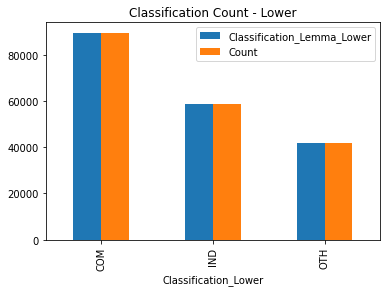

In [23]:
# Words to classification description as IND
industry_tokens = ["mining","mill","manufacture","industrial","material","chemical","part","unit","machine","manufacturing"
                    ,"fuel","water","electric","generate","quarry","industrial","facil","equipment","metal","freight"
                ]


# Words to classification description as COM
commerical_tokens = ["service","sale","admin","office","wholesaler","financ"
                    ,"store","clothing","support","salon","broadcast","intermediat","agency","dealer"
                    ,"appraiser","telecommunication","sell","bank","repair","school","commercial","merchandise", "professional"
                    ,"advertis","publisher","agency","contractor","research","real","estate","social","markets","information","insurance","trade"
                    ,"hospitals","rental","construction"]



all_years_df["Classification_Lower"] = (all_years_df["Description_Lower"]
                                 .apply(lambda description: assign_classification(description,industry_tokens,commerical_tokens))
                                 
                                 )

all_years_df["Classification_Lemma_Lower"] = (all_years_df["Description_Lemma_Lower"]
                                 .apply(lambda description: assign_classification(description,industry_tokens,commerical_tokens))

                                    )



_ = (all_years_df[["Classification_Lower","Classification_Lemma_Lower","STATE"]].groupby('Classification_Lower').count()
.rename(columns={"STATE":"Count"})
.sort_values("Count",ascending=False)
).plot(kind="bar",title="Classification Count - Lower")

In [28]:
all_years_df

,STATE,DESCRIPTION,YEAR,Employment,Establishments,Firms,Description_Lemma_Lower,Description_Lower,Classification_Lower,Classification_Lemma_Lower
0,AL,Accommodation & foodservices,2001,127776.0,6870.0,4697.0,accommodation & foodservice,accommodation & foodservices,COM,COM
1,AL,Accommodation & foodservices,2002,128964.0,7070.0,4801.0,accommodation & foodservice,accommodation & foodservices,COM,COM
2,AL,Accommodation and Food Services,2003,139440.0,7178.0,4918.0,accommodation and food services,accommodation and food services,COM,COM
3,AL,Accommodation and Food Services,2004,141442.0,7292.0,5089.0,accommodation and food services,accommodation and food services,COM,COM
4,AL,Accommodation and Food Services,2005,145447.0,7529.0,5256.0,accommodation and food services,accommodation and food services,COM,COM
...,...,...,...,...,...,...,...,...,...,...
189898,WY,Political Organizations,2018,34.0,13.0,13.0,political organization,political organizations,OTH,OTH
189899,WY,Political Organizations,2018,34.0,13.0,13.0,political organization,political organizations,OTH,OTH
189900,WY,"Other Similar Organizations (except Business, ...",2018,70.0,18.0,18.0,"other similar organization ( except business ,...","other similar organizations (except business, ...",COM,COM
189901,WY,"Other Similar Organizations (except Business, ...",2018,70.0,18.0,18.0,"other similar organization ( except business ,...","other similar organizations (except business, ...",COM,COM


In [29]:

# Most frequently used words in OTH description

description_list = all_years_df.query('Classification_Lemma_Lower == "OTH"')["Description_Lemma_Lower"].to_list()

count_dictionary = dict()


for description in description_list:

    for token in description.split(" "):

        if token.strip() in count_dictionary.keys():

            count_dictionary[token] += 1

        else:

            count_dictionary[token] = 1


pd.DataFrame([count_dictionary]).T.rename(columns={0:"Count"}).sort_values("Count",ascending=False).head(50)

,Count
and,19872
",",9384
transportation,3858
other,3791
of,2583
(,1979
),1979
centers,1927
warehousing,1848
recreation,1530


### Add state abbreviations

In [30]:
state_abbrev = []
for s in all_years_df['STATE']:
  if s != 'United States':
    state_object = us.states.lookup(s)
    state_abbrev.append(state_object.abbr)
  else:
    state_abbrev.append(np.nan)
all_years_df['STATE'] = state_abbrev

In [31]:
all_years_df.isnull().sum()

STATE                           0
DESCRIPTION                     0
YEAR                            0
Employment                    222
Establishments                  0
Firms                           0
Description_Lemma_Lower         0
Description_Lower               0
Classification_Lower            0
Classification_Lemma_Lower      0
dtype: int64

In [32]:
# there are a lot of places where STATE is null because the value was total for the whole United STates so these should be removed
all_years_df = all_years_df[~all_years_df['STATE'].isnull()].copy()

In [33]:
all_years_df.isnull().sum()

STATE                           0
DESCRIPTION                     0
YEAR                            0
Employment                    222
Establishments                  0
Firms                           0
Description_Lemma_Lower         0
Description_Lower               0
Classification_Lower            0
Classification_Lemma_Lower      0
dtype: int64

In [34]:
# now save this dataframe
all_years_df.to_csv('/content/drive/Shareddrives/Data606_Energy/data/fill_ready/SUSB_data_all_2001_2018.csv', index=False)

In [38]:
all_years_df

,STATE,DESCRIPTION,YEAR,Employment,Establishments,Firms,Description_Lemma_Lower,Description_Lower,Classification_Lower,Classification_Lemma_Lower
0,AL,Accommodation & foodservices,2001,127776.0,6870.0,4697.0,accommodation & foodservice,accommodation & foodservices,COM,COM
1,AL,Accommodation & foodservices,2002,128964.0,7070.0,4801.0,accommodation & foodservice,accommodation & foodservices,COM,COM
2,AL,Accommodation and Food Services,2003,139440.0,7178.0,4918.0,accommodation and food services,accommodation and food services,COM,COM
3,AL,Accommodation and Food Services,2004,141442.0,7292.0,5089.0,accommodation and food services,accommodation and food services,COM,COM
4,AL,Accommodation and Food Services,2005,145447.0,7529.0,5256.0,accommodation and food services,accommodation and food services,COM,COM
...,...,...,...,...,...,...,...,...,...,...
189898,WY,Political Organizations,2018,34.0,13.0,13.0,political organization,political organizations,OTH,OTH
189899,WY,Political Organizations,2018,34.0,13.0,13.0,political organization,political organizations,OTH,OTH
189900,WY,"Other Similar Organizations (except Business, ...",2018,70.0,18.0,18.0,"other similar organization ( except business ,...","other similar organizations (except business, ...",COM,COM
189901,WY,"Other Similar Organizations (except Business, ...",2018,70.0,18.0,18.0,"other similar organization ( except business ,...","other similar organizations (except business, ...",COM,COM


In [39]:
tokens = [{"IND":industry_tokens,
 "COM":commerical_tokens}]

df = pd.DataFrame(tokens).T.reset_index().rename(columns={"index":"Classification",0:"tokens"}).explode("tokens")

df["count"] = 1

In [42]:
import plotly.express as px

fig = px.bar(df,x="Classification",y="count",text="tokens",title="Tokens Search for to Determine Classification")

fig.update_layout(
    autosize=False,
    width=2000,
    height=1000,
)

